# *The Art of Natural Language Processing: Machine Learning for the Case Study*

### **Authors: Andrea Ferrario, Mara Nägelin**

**Date: February 2020** (updated September 2020)

Notebook to run the machine learning modeling in the Classical and Modern Approaches, as described in the tutorial `The Art of Natural Language Processing: Classical, Modern and Contemporary Approaches to Text Document Classification'.

# Table of contents
1. [Getting started with Python and Jupyter Notebook](#started)
2. [Import data](#import)
3. [Duplicated reviews](#duplicated)
4. [Data preprocessing](#preprocessing)
5. [POS-tagging](#POS)
6. [Pre-trained word embeddings](#emb)
7. [Data analytics](#analytics)  
    7.1. [A quick check of data structure](#check)  
    7.2. [Basic linguistic analysis of movie reviews](#basic)
8. [Machine learning](#ML)  
    8.1. [Adaptive boosting (ADA)](#ADA)  
    .......8.1.1. [Bag-of-words](#ADA_BOW)  
    .......8.1.2. [Bag-of-POS](#ADA_BOP)  
    .......8.1.3. [Embeddings](#ADA_E)  
    8.2. [Random forests (RF)](#RF)  
    .......8.2.1. [Bag-of-words](#RF_BOW)  
    .......8.2.2. [Bag-of-POS](#RF_BOP)  
    .......8.2.3. [Embeddings](#RF_E)  
    8.3. [Extreme gradient boosting (XGB)](#XGB)  
    .......8.3.1. [Bag-of-words](#XGB_BOW)  
    .......8.3.2. [Bag-of-POS](#XGB_BOP)  
    .......8.3.3. [Embeddings](#XGB_E)

# 1. Getting started with Python and Jupyter Notebook<a name="started"></a>

In this section, Jupyter Notebook and Python settings are initialized. For code in Python, the [PEP8 standard](https://www.python.org/dev/peps/pep-0008/) ("PEP = Python Enhancement Proposal") is enforced with minor variations to improve readibility.

In [1]:
# Notebook settings
###################

# resetting variables
get_ipython().magic('reset -sf') 

# formatting: cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# plotting
%matplotlib inline

# 2. Import data<a name="import"></a>

In [2]:
# we use the import function, as in Chapter 8 of Raschka's book (see the tutorial)
import pyprind
import pandas as pd
import os
basepath = '...' # insert basepath, where original data are stored

labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(50000)
df = pd.DataFrame()
for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join(basepath, s, l)
        for file in os.listdir(path):
            with open(os.path.join(path, file), 
                      'r', encoding='utf-8') as infile:
                txt = infile.read()
            df = df.append([[txt, labels[l]]], 
                           ignore_index=True)
            pbar.update()
df.columns = ['review', 'sentiment']

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:54


# 3. Duplicated reviews<a name="duplicated"></a>

In [3]:
# check for duplicates
duplicates = df[df.duplicated()]  #equivalent to keep = first. Duplicated rows, except the first entry, are marked as 'True'
print(len(duplicates))

418


In [4]:
# a check on the duplicated review
duplicates.review   

33       I was fortunate to attend the London premier o...
177      I've been strangely attracted to this film sin...
939      The Andrew Davies adaptation of the Sarah Wate...
1861     <br /><br />First of all, I reviewed this docu...
1870     Spheeris debut must be one of the best music d...
                               ...                        
49412    There is no way to avoid a comparison between ...
49484    **SPOILERS** I rented "Tesis" (or "Thesis" in ...
49842    'Dead Letter Office' is a low-budget film abou...
49853    This movie had a IMDB rating of 8.1 so I expec...
49864    You know all those letters to "Father Christma...
Name: review, Length: 418, dtype: object

In [5]:
# remove duplicates: 
df = df.drop_duplicates()
df.shape

(49582, 2)

In [6]:
# double check
df[df.duplicated(subset='review')]

,review,sentiment


# 4. Data preprocessing<a name="preprocessing"></a>

In [7]:
# an example of 'raw' review: we have all sort of HTML markup
df.loc[500, 'review']

'I have always liked this film and I\'m glad it\'s available finally on DVD so more viewers can see what I have been telling them all these years. Story is about a high school virgin named Gary (Lawrence Monoson) who works at a pizza place as a delivery boy and he hangs out with his friends David (Joe Rubbo) and Rick (Steve Antin). Gary notices Karen (Diane Franklin) who is the new girl in school and one morning he gives her a ride and by this time he is totally in love. That night at a party he see\'s Rick with Karen and now he is jealous of his best friend but doesn\'t tell anyone of his true feelings.<br /><br />*****SPOILER ALERT*****<br /><br />Rick asks Gary if he can borrow his Grandmothers vacant home but Gary makes up an excuse so that Rick can\'t get Karen alone. But one night Rick brags to Gary that he nailed her at the football field and Gary becomes enraged. A few days later in the school library Gary see\'s Rick and Karen arguing and he asks Karen what is wrong. She tells

In [8]:
# preprocessing by Raschka, Chpater 8 (see tutorial)
# we remove all markups, substitute non-alphanumeric characters (including 
# underscore) with whitespaces, and remove the nose from emoticons
import re

def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

df['review'] = df['review'].apply(preprocessor)

In [9]:
# checking again the same review
df.loc[500, 'review']

'i have always liked this film and i m glad it s available finally on dvd so more viewers can see what i have been telling them all these years story is about a high school virgin named gary lawrence monoson who works at a pizza place as a delivery boy and he hangs out with his friends david joe rubbo and rick steve antin gary notices karen diane franklin who is the new girl in school and one morning he gives her a ride and by this time he is totally in love that night at a party he see s rick with karen and now he is jealous of his best friend but doesn t tell anyone of his true feelings spoiler alert rick asks gary if he can borrow his grandmothers vacant home but gary makes up an excuse so that rick can t get karen alone but one night rick brags to gary that he nailed her at the football field and gary becomes enraged a few days later in the school library gary see s rick and karen arguing and he asks karen what is wrong she tells him that she s pregnant and that rick has dumped her

In [10]:
# save preprocessed data as csv 
path = '...'  # insert path
df.to_csv(path, index=False, encoding='utf-8')

# 5. POS - tagging<a name="POS"></a>

In [11]:
# we apply POS-tagging on (deduplicated and) pre-processed data - let us import them
path = '...' # insert path
df = pd.read_csv(path, encoding='utf-8')
df.shape

(49582, 2)

In [12]:
# we import the NLTK resources
import nltk
from nltk import pos_tag, word_tokenize

# introduction of POS tagger per NLTK token
def pos_tags(text):
    text_processed = word_tokenize(text)
    return "-".join( tag for (word, tag) in nltk.pos_tag(text_processed))

# applying POS tagger to data 
############################################
df['text_pos']=df.apply(lambda x: pos_tags(x['review']), axis=1)

In [13]:
# save POS-tagged data as csv 
path = '...' # insert path 
df.to_csv(path, index=False, encoding='utf-8')

# 6. Pre-trained word embeddings<a name="emb"></a>

In [14]:
# we apply embeddings on de-duplicated and pre-processed data - let us import them
path = '...' # insert path
df = pd.read_csv(path, encoding='utf-8')
df.shape

(49582, 2)

In [15]:
# import pre-trained word embedding model
import spacy
nlp = spacy.load('en_core_web_md') # load the model first if necessary: python -m spacy download en_core_web_md

In [16]:
# we stack (like a numpy vertical stack) the 300 variables obtained from averaging the embedding of each df.review entry
# WARNING: this is computationally expensive. Alternatively try with the smaller model en_core_web_sm
import numpy as np
emb = np.vstack(df.review.apply(lambda x: nlp(x).vector))

In [17]:
# embeddings into a dataframe
emb = pd.DataFrame(emb, columns = np.array([str(x) for x in range(0, 299 + 1)]) )
print(emb.shape)
print(emb.columns.values)

(49582, 300)
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43'
 '44' '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55' '56' '57'
 '58' '59' '60' '61' '62' '63' '64' '65' '66' '67' '68' '69' '70' '71'
 '72' '73' '74' '75' '76' '77' '78' '79' '80' '81' '82' '83' '84' '85'
 '86' '87' '88' '89' '90' '91' '92' '93' '94' '95' '96' '97' '98' '99'
 '100' '101' '102' '103' '104' '105' '106' '107' '108' '109' '110' '111'
 '112' '113' '114' '115' '116' '117' '118' '119' '120' '121' '122' '123'
 '124' '125' '126' '127' '128' '129' '130' '131' '132' '133' '134' '135'
 '136' '137' '138' '139' '140' '141' '142' '143' '144' '145' '146' '147'
 '148' '149' '150' '151' '152' '153' '154' '155' '156' '157' '158' '159'
 '160' '161' '162' '163' '164' '165' '166' '167' '168' '169' '170' '171'
 '172' '173' '174' '175' '176' '177' '178' '179' '18

In [18]:
# join embeddings with dataframe
df_embed = pd.concat([df, emb], axis=1)

In [19]:
# check the shape of the resulting dataframe
df_embed.shape

(49582, 302)

In [20]:
# save word embedding data as csv 
path = '...' # insert path
df_embed.to_csv(path, index=False, encoding='utf-8')

# 7. Data analytics<a name="analytics"></a>

We reproduce main data analytics results in Section 6.3 of the tutorial. We use the preprocessed and deduplicated data, for simplicity.

## 7.1. A quick check of data structure<a name="check"></a>

In [21]:
# importing data
import pandas as pd

path = '...' # insert path for deduplicated and preprocessed data
df = pd.read_csv(path)

In [22]:
# imported data structure
df.shape

(49582, 2)

In [23]:
# columns in data
df.columns

Index(['review', 'sentiment'], dtype='object')

In [24]:
# imported data: first 10 entries
df.head(10)

,review,sentiment
0,i went and saw this movie last night after bei...,1
1,actor turned director bill paxton follows up h...,1
2,as a recreational golfer with some knowledge o...,1
3,i saw this film in a sneak preview and it is d...,1
4,bill paxton has taken the true story of the 19...,1
5,i saw this film on september 1st 2005 in india...,1
6,maybe i m reading into this too much but i won...,1
7,i felt this film did have many good qualities ...,1
8,this movie is amazing because the fact that th...,1
9,quitting may be as much about exiting a pre o...,1


In [25]:
# counts of rviews per sentiment value
df.sentiment.value_counts()

1    24884
0    24698
Name: sentiment, dtype: int64

## 7.2. Basic linguistic analysis of movie reviews<a name="basic"></a>

In [26]:
# show distribution of review lenghts 
# we strip leading and trailing whitespaces and tokenize by whitespace
df['word_count'] = df['review'].apply(lambda x: len(x.strip().split(" ")))
df[['review','sentiment', 'word_count']].head(10)

,review,sentiment,word_count
0,i went and saw this movie last night after bei...,1,153
1,actor turned director bill paxton follows up h...,1,353
2,as a recreational golfer with some knowledge o...,1,247
3,i saw this film in a sneak preview and it is d...,1,128
4,bill paxton has taken the true story of the 19...,1,206
5,i saw this film on september 1st 2005 in india...,1,318
6,maybe i m reading into this too much but i won...,1,344
7,i felt this film did have many good qualities ...,1,144
8,this movie is amazing because the fact that th...,1,174
9,quitting may be as much about exiting a pre o...,1,959


In [27]:
# summary statistics of word counts
print(df['word_count'].describe())

count    49582.000000
mean       235.660340
std        174.444773
min          6.000000
25%        129.000000
50%        177.000000
75%        286.000000
max       2498.000000
Name: word_count, dtype: float64


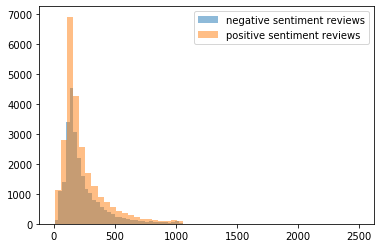

In [28]:
# show histograms of word counts divided per sentiment
from matplotlib import pyplot

x = df[df['sentiment']==0].word_count
y = df[df['sentiment']==1].word_count

pyplot.hist(x, bins=50, alpha=0.5, label='negative sentiment reviews')
pyplot.hist(y, bins=50, alpha=0.5, label='positive sentiment reviews')
pyplot.legend(loc='upper right')
pyplot.show()

In [29]:
# summary of distributions of word counts
print(x.describe())
print(y.describe())

count    24698.000000
mean       234.109847
std        168.079121
min          6.000000
25%        131.000000
50%        178.000000
75%        283.000000
max       1550.000000
Name: word_count, dtype: float64
count    24884.000000
mean       237.199244
std        180.531262
min         10.000000
25%        127.000000
50%        176.000000
75%        288.000000
max       2498.000000
Name: word_count, dtype: float64


In [30]:
# some checks (e.g. word_counts=6 or 1550 or 2498 )
df[df['word_count']==6]

,review,sentiment,word_count
19476,primary plot primary direction poor interpreta...,0,6
21333,read the book forget the movie,0,6


In [31]:
# average word length (again, we tokenize by whitespaces)
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

df['avg_word'] = df['review'].apply(lambda x: avg_word(x.strip()))
df[['review','word_count', 'sentiment', 'avg_word']].head(10)

,review,word_count,sentiment,avg_word
0,i went and saw this movie last night after bei...,153,1,4.091503
1,actor turned director bill paxton follows up h...,353,1,4.501416
2,as a recreational golfer with some knowledge o...,247,1,4.607287
3,i saw this film in a sneak preview and it is d...,128,1,4.085938
4,bill paxton has taken the true story of the 19...,206,1,4.723301
5,i saw this film on september 1st 2005 in india...,318,1,4.544025
6,maybe i m reading into this too much but i won...,344,1,4.270349
7,i felt this film did have many good qualities ...,144,1,4.652778
8,this movie is amazing because the fact that th...,174,1,4.436782
9,quitting may be as much about exiting a pre o...,959,1,4.503650


In [32]:
# distributions of word lengths conditional per sentiment
x = df[df['sentiment']==0].avg_word
y = df[df['sentiment']==1].avg_word
print(x.describe())
print()
print(y.describe())

count    24698.000000
mean         4.266094
std          0.287540
min          2.917808
25%          4.073807
50%          4.253968
75%          4.447635
max          7.500000
Name: avg_word, dtype: float64

count    24884.000000
mean         4.325630
std          0.318722
min          3.137931
25%          4.114986
50%          4.316667
75%          4.526851
max         11.673077
Name: avg_word, dtype: float64


In [33]:
# some checks (e.g. avg_word>=11)
df[df['avg_word']>=11]

,review,sentiment,word_count,avg_word
11985,whoops looks like it s gonna cost you a whopp...,1,52,11.673077


In [34]:
# stop words statistics - stopword from NLTK
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['stopwords'] = df['review'].apply(lambda x: len([x for x in x.strip().split() if x in stop]))
df[['review','word_count', 'sentiment', 'avg_word', 'stopwords']].head(10)

,review,word_count,sentiment,avg_word,stopwords
0,i went and saw this movie last night after bei...,153,1,4.091503,82
1,actor turned director bill paxton follows up h...,353,1,4.501416,167
2,as a recreational golfer with some knowledge o...,247,1,4.607287,123
3,i saw this film in a sneak preview and it is d...,128,1,4.085938,71
4,bill paxton has taken the true story of the 19...,206,1,4.723301,91
5,i saw this film on september 1st 2005 in india...,318,1,4.544025,144
6,maybe i m reading into this too much but i won...,344,1,4.270349,184
7,i felt this film did have many good qualities ...,144,1,4.652778,68
8,this movie is amazing because the fact that th...,174,1,4.436782,93
9,quitting may be as much about exiting a pre o...,959,1,4.503650,460


In [35]:
# distributions of stop words conditional per sentiment
x = df[df['sentiment']==0].stopwords
y = df[df['sentiment']==1].stopwords
print(x.describe())
print()
print(y.describe())

count    24698.000000
mean       116.211556
std         83.499135
min          0.000000
25%         65.000000
50%         89.000000
75%        140.000000
max        726.000000
Name: stopwords, dtype: float64

count    24884.000000
mean       115.732238
std         87.736974
min          3.000000
25%         62.000000
50%         87.000000
75%        140.000000
max       1208.000000
Name: stopwords, dtype: float64


In [36]:
# some checks (e.g. stopwords==0)
df[df['stopwords']==0]

,review,sentiment,word_count,avg_word,stopwords
19476,primary plot primary direction poor interpreta...,0,6,7.5,0


# 8. Machine Learning<a name="ML"></a>

We replicate the machine learning pipelines from the tutorial, Section 6.4 (Classical and Modern Approaches).

**WARNING**: as mentioned in the tutorial, the following cross-validation routines are computationally intensive. We recommend to sub-sample data and/or use HPC infrastructure (specifying the parameter njobs in GridSearch() accordingly). Test runs can be launched on reduced hyperparameter grids, as well. 
Note that we ran all the machine learning routines presented in this section on the ETH High Performance Computing (HPC) infrastructure [Euler](https://scicomp.ethz.ch/wiki/Euler), by submitting all jobs to a virtual machine consisting of 32 cores with 3072 MB RAM per core (total RAM: 98.304 GB). Therefore, notebook cell outputs are not available for this section.

## 8.1. Adaptive boosting (ADA)<a name="ADA"></a>

We use the adaptive boosting (ADA) algorithm on top of NLP pipelines (bag-of models and pre-trained word embeddings).

### 8.1.1. Bag-of-words<a name="ADA_BOW"></a>

In [ ]:
# loading Python packages
#########################

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# data preparation
###########################################

# data import 
import pandas as pd

path = '...'  # insert path to deduplicated and preprocessed data
df = pd.read_csv(path)     

# shuffling data
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# introducing the stopwords
###########################################

# stopwords
import nltk
from nltk.corpus import stopwords
stopwords = list(set(stopwords.words('english')))

# train vs. test: we already shuffled data -80/20 split
##########################################

X_train = df.head(39666).review
y_train = df.head(39666).sentiment

X_test = df.tail(9916).review
y_test = df.tail(9916).sentiment

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('X_train shape check: ', X_train.shape)
print('X_test shape check: ', X_test.shape)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = {'vect__ngram_range': [(1, 1)],           # choose (1, 2) to compute 2-grams
              'vect__stop_words': [stopwords, None],
              'vect__max_df': [1.0, 0.1, 0.3, 0.5],
              'vect__max_features': [None, 1000],                                          
              'clf__n_estimators': [100, 200, 300, 400],
              'clf__learning_rate': [0.001, 0.01, 0.1, 1.0]
              }

tree = DecisionTreeClassifier(max_depth=5)

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', AdaBoostClassifier(base_estimator=tree))]
                    )

# on cross-validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False
                     )

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='roc_auc',
                           cv=cv, 
                           n_jobs=)               # insert the number of jobs, according to the used machine

# running the grid
###########################################

gs_lr_tfidf.fit(X_train, y_train)

# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# AUC on test data
auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Test AUC: %.3f' % auc_res)
print('Test Accuracy: %.3f' % acc)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

### 8.1.2. Bag-of-POS<a name="ADA_BOP"></a>

In [ ]:
# loading Python packages
#########################

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# data preparation
###########################################

# data import
import pandas as pd

path = '...'  # insert path to data with POS-tags
df = pd.read_csv(path)

# shuffling data
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# train vs. test: we already shuffled data -80/20 split
##########################################

X_train = df.head(39666).text_pos
y_train = df.head(39666).sentiment

X_test = df.tail(9916).text_pos
y_test = df.tail(9916).sentiment

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('X_train shape check: ', X_train.shape)
print('X_test shape check: ', X_test.shape)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = {'vect__ngram_range': [(1, 1)],               # we consider only 1-gram POS (for 2-grams: (1,2))
              'clf__n_estimators': [100, 200, 300, 400],
              'clf__learning_rate': [0.001, 0.01, 0.1, 1.0]}

tree = DecisionTreeClassifier(max_depth=5)

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', AdaBoostClassifier(base_estimator=tree))]
                    )

# on cross-validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False
                     )

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='roc_auc',
                           cv=cv, 
                           n_jobs=)                        # insert the number of jobs, according to the used machine

# running the grid
###########################################

gs_lr_tfidf.fit(X_train, y_train)

# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# AUC on test data
auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Test AUC: %.3f' % auc_res)
print('Test Accuracy: %.3f' % acc)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

### 8.1.3. Embeddings<a name="ADA_E"></a>

In [ ]:
# loading Python packages
#########################

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# data preparation
###########################################

# data import
import pandas as pd

path = '...'  # insert path to data with pre-trained word embeddings
df = pd.read_csv(path)

# shuffling data
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# train vs. test: we already shuffled data -80/20 split - drop the variables
############################################################################

X_train = df.drop(columns=['review', 'sentiment']).head(39666)    # we use only the 300 embeddings
y_train = df.head(39666).sentiment

X_test = df.drop(columns=['review', 'sentiment']).tail(9916)      # we use only the 300 embeddings
y_test = df.tail(9916).sentiment

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('X_train shape check: ', X_train.shape)
print('X_test shape check: ', X_test.shape)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'clf__n_estimators': [100, 200, 300, 400],
              'clf__learning_rate': [0.001, 0.01, 0.1, 1.0]}

# extended parameter grid (Table 6, Section 6.4.5 in the tutorial)
# param_grid = {'clf__n_estimators': [100, 200, 300, 400, 500, 700, 900, 1000],
#              'clf__learning_rate': [0.001, 0.01, 0.1, 1.0]}

tree = DecisionTreeClassifier(max_depth=5)

pipe = Pipeline([('clf', AdaBoostClassifier(base_estimator=tree))])

# on cross-validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False
                     )

gs_lr_tfidf = GridSearchCV(pipe, param_grid,
                           scoring='accuracy',
                           cv=cv, 
                           n_jobs=)                        # insert the number of jobs, according to the used machine

# running the grid
###########################################

gs_lr_tfidf.fit(X_train, y_train)

# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# AUC on test data
auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Test AUC: %.3f' % auc_res)
print('Test Accuracy: %.3f' % acc)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

## 8.2. Random Forests (RF)<a name="RF"></a>

We use the random forests (RF) algorithm on top of NLP pipelines (bag-of models and pre-trained word embeddings).

### 8.2.1. Bag-of-words<a name="RF_BOW"></a>

In [ ]:
# loading Python packages
#########################

from sklearn.utils import shuffle 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# data preparation
###########################################

# data import
import pandas as pd

path = '...'  # insert path to deduplicated and preprocessed data
df = pd.read_csv(path)

# shuffling data
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# introducing the stopwords
###########################################

# stopwords
import nltk
from nltk.corpus import stopwords
stopwords = list(set(stopwords.words('english')))

# train vs. test: we already shuffled data -80/20 split
##########################################

X_train = df.head(39666).review
y_train = df.head(39666).sentiment

X_test = df.tail(9916).review
y_test = df.tail(9916).sentiment

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('X_train shape check: ', X_train.shape)
print('X_test shape check: ', X_test.shape)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = {'vect__ngram_range': [(1, 1)],    # for 2-grams:(1, 2)
              'vect__stop_words': [stopwords, None],
              'vect__max_df': [1.0, 0.1, 0.3, 0.5],
              'vect__max_features': [None, 1000],                                           
              'clf__n_estimators': [100, 200, 300, 400],
              'clf__max_depth': [1, 5, 10]
              }

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', RandomForestClassifier())]
                    )

# on cross-validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False
                     )

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='roc_auc',
                           cv=cv, 
                           n_jobs=)       # insert the number of jobs, according to the used machine

# running the grid
###########################################

gs_lr_tfidf.fit(X_train, y_train)

# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# AUC on test data
auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Test AUC: %.3f' % auc_res)
print('Test Accuracy: %.3f' % acc)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

### 8.2.2. Bag-of-POS<a name="RF_BOP"></a>

In [ ]:
# loading Python packages
#########################

from sklearn.utils import shuffle 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# data preparation
###########################################

# data import
import pandas as pd

path = '...'  # insert path to data with POS-tags
df = pd.read_csv(path)

# shuffling data
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# train vs. test: we already shuffled data -80/20 split
##########################################

X_train = df.head(39666).text_pos
y_train = df.head(39666).sentiment

X_test = df.tail(9916).text_pos
y_test = df.tail(9916).sentiment

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('X_train shape check: ', X_train.shape)
print('X_test shape check: ', X_test.shape)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = {'vect__ngram_range': [(1, 1)],               # we consider only 1-gram POS (for 2-grams: (1,2))
              'clf__n_estimators': [100, 200, 300, 400],
              'clf__max_depth': [1, 5, 10]
              }

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', RandomForestClassifier())]
                    )

# on cross-validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False
                     )

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='roc_auc',
                           cv=cv, 
                           n_jobs=)              # insert the number of jobs, according to the used machine

# running the grid
###########################################

gs_lr_tfidf.fit(X_train, y_train)

# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# AUC on test data
auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Test AUC: %.3f' % auc_res)
print('Test Accuracy: %.3f' % acc)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

### 8.2.3. Embeddings<a name="RF_E"></a>

In [ ]:
# loading Python packages
#########################

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# data preparation
###########################################

# data import 
import pandas as pd

path = '...'  # insert path to data with pre-trained word embeddings
df = pd.read_csv(path)

# shuffling data
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# train vs. test: we already shuffled data -80/20 split - drop the variables
############################################################################

X_train = df.drop(columns=['review', 'sentiment']).head(39666)    # we use only the 300 embeddings
y_train = df.head(39666).sentiment

X_test = df.drop(columns=['review', 'sentiment']).tail(9916)     # we use only the 300 embeddings
y_test = df.tail(9916).sentiment

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('X_train shape check: ', X_train.shape)
print('X_test shape check: ', X_test.shape)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


param_grid = {
              'clf__n_estimators': [100, 200, 300, 400],
              'clf__max_depth': [1, 5, 10]
             }

# extended parameter grid (Table 6, Section 6.4.5 in the tutorial)
# param_grid = {'clf__n_estimators': [100, 200, 300, 400, 500, 600, 800, 1000],
#              'clf__max_depth': [1, 5, 10, 20]}

pipe = Pipeline([('clf', RandomForestClassifier())
               ])

# on cross-validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False
                     )

gs_lr_tfidf = GridSearchCV(pipe, param_grid,
                           scoring='roc_auc',
                           cv=cv, 
                           n_jobs=)               # insert the number of jobs, according to the used machine

# running the grid
###########################################

gs_lr_tfidf.fit(X_train, y_train)

# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# AUC on test data
auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Test AUC: %.3f' % auc_res)
print('Test Accuracy: %.3f' % acc)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

## 8.3. Extreme gradient boosting (XGB)<a name="XGB"></a>

We use the extreme gradient boosting (XGB) algorithm on top of NLP pipelines (bag-of models and pre-trained word embeddings). We can use the cell below to install xgboost, if other imports failed.

In [ ]:
# importing xgboost REMARK: run this cell only if other imports failed. Delete it in case xgboost has been already imported
import pip
pip.main(['install', 'xgboost'])

### 8.3.1. Bag-of-words<a name="XGB_BOW"></a>

In [ ]:
# loading Python packages
#########################

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# data preparation
###########################################

# data import
import pandas as pd

path = '...'  # insert path to preprocessed and deduplicated data
df = pd.read_csv(path)

# shuffling data
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# introducing the stopwords
###########################################

# stopwords
import nltk
from nltk.corpus import stopwords
stopwords = list(set(stopwords.words('english')))

# train vs. test: we already shuffled data -80/20 split
##########################################

X_train = df.head(39666).review
y_train = df.head(39666).sentiment

X_test = df.tail(9916).review
y_test = df.tail(9916).sentiment

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('X_train shape check: ', X_train.shape)
print('X_test shape check: ', X_test.shape)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = {'vect__ngram_range': [(1, 1)]    # for 2-grams: (1,2)
              'vect__stop_words': [stopwords, None],
              'vect__max_df': [1.0, 0.1, 0.3, 0.5],
              'vect__max_features': [None, 1000],                                           
              'clf__n_estimators': [100, 300, 500, 1000],
              'clf__learning_rate': [0.001, 0.01, 0.1, 1.0],
              'clf__max_depth': [1, 10, 20]
              }

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', XGBClassifier())]
                    )

# on cross-validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False
                     )

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='roc_auc',
                           cv=cv, 
                           n_jobs=)                 # insert the number of jobs, according to the used machine

# running the grid
###########################################

gs_lr_tfidf.fit(X_train, y_train)

# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# AUC on test data
auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Test AUC: %.3f' % auc_res)
print('Test Accuracy: %.3f' % acc)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

### 8.3.2. Bag-of-POS<a name="XGB_BOP"></a>

In [ ]:
# loading Python packages
#########################

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# data preparation
###########################################

# data import
import pandas as pd

path = '...'  # insert data with POS-tags
df = pd.read_csv(path)

# shuffling data
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# train vs. test: we already shuffled data -80/20 split
##########################################

X_train = df.head(39666).review
y_train = df.head(39666).sentiment

X_test = df.tail(9916).review
y_test = df.tail(9916).sentiment

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('X_train shape check: ', X_train.shape)
print('X_test shape check: ', X_test.shape)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = {'vect__ngram_range': [(1, 1)],               # we consider only 1-gram POS (for 2-grams: (1,2))
              'clf__n_estimators': [100, 300, 500, 1000],
              'clf__learning_rate': [0.001, 0.01, 0.1, 1.0],
              'clf__max_depth': [1, 10, 20]
              }

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', XGBClassifier())]
                    )


# on cross-validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False
                     )


gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='roc_auc',
                           cv=cv, 
                           n_jobs=)              # insert the number of jobs, according to the used machine

# running the grid
###########################################

gs_lr_tfidf.fit(X_train, y_train)

# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# AUC on test data
auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Test AUC: %.3f' % auc_res)
print('Test Accuracy: %.3f' % acc)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

### 8.3.3. Embeddings<a name="XGB_E"></a>

In [ ]:
# loading Python packages
#########################

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# data preparation
###########################################

# data import
import pandas as pd

path = '...'  # insert data with pre-trained word embeddings
df = pd.read_csv(path)

# shuffling data
import numpy as np

np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

# train vs. test: we already shuffled data -80/20 split - drop the variables
############################################################################

X_train = df.drop(columns=['review', 'sentiment']).head(39666)    # we use only the 300 embeddings
y_train = df.head(39666).sentiment

X_test = df.drop(columns=['review', 'sentiment']).tail(9916)     # we use only the 300 embeddings
y_test = df.tail(9916).sentiment

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('X_train shape check: ', X_train.shape)
print('X_test shape check: ', X_test.shape)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')

# GridSearch()
###########################################

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
              'clf__n_estimators': [100, 300, 500, 1000],
              'clf__learning_rate': [0.001, 0.01, 0.1, 1.0],
              'clf__max_depth': [1, 10, 20]
              }

pipe = Pipeline([('clf', XGBClassifier())
                ])
                    
# on cross-validation parameters
cv = StratifiedKFold(n_splits=5, 
                     shuffle=False
                     )

gs_lr_tfidf = GridSearchCV(pipe, param_grid,
                           scoring='roc_auc',
                           cv=cv, 
                           n_jobs=)        # insert the number of jobs, according to the used machine

# running the grid
###########################################

gs_lr_tfidf.fit(X_train, y_train)

# best estimator - test performance
###########################################

clf_b = gs_lr_tfidf.best_estimator_
y_pred_proba = clf_b.predict_proba(X_test)
y_pred = clf_b.predict(X_test)

# AUC on test data
auc_res=roc_auc_score(y_test, y_pred_proba[:, 1])

# Accuracy on test data
acc = accuracy_score(y_test, y_pred)

# collecting results
###########################################

print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')
print('Test AUC: %.3f' % auc_res)
print('Test Accuracy: %.3f' % acc)
print('---------------------')
print('---------------------')
print('---------------------')
print('---------------------')